In [ ]:
import torch
from torchvision import transforms, utils
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import random
import os
import numpy as np
import argparse
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset loader
transforms_orig = transforms.Compose([
                transforms.RandomRotation(15),
                transforms.Resize((128, 128), Image.BICUBIC),
                transforms.RandomHorizontalFlip()])

transforms_bw = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()])


transforms_rgb = transforms.Compose([
                transforms.ToTensor()])

class ImageDataset(Dataset):
    def __init__(self, root, transforms_orig=None, transforms_bw=None, transforms_rgb=None):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''

        files = glob.glob('%s/*.*' % root)
        self.training_files = files * 4
        self.transforms_orig = transforms_orig
        self.transforms_rgb = transforms_rgb
        self.transforms_bw = transforms_bw

    def __len__(self):
        return len(self.training_files)

    def __getitem__(self, idx):
        img = Image.open(self.training_files[idx])

        orig_image = self.transforms_orig(img)

        true_image = self.transforms_rgb(orig_image)
        bw_image = self.transforms_bw(orig_image)

        return {"true_image": true_image, "gen_image": bw_image}

In [ ]:
training_generator = ImageDataset(root="/content/drive/MyDrive/CISC 867 Project/training_images", transforms_orig=transforms_orig,
                                                    transforms_rgb=transforms_rgb,
                                                    transforms_bw=transforms_bw)


In [ ]:
batch_size = 5
dataloader = DataLoader(
    training_generator,
    batch_size=batch_size,
    shuffle=True
)

torch.Size([5, 3, 128, 128])


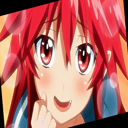

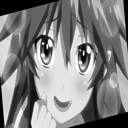

torch.Size([5, 3, 128, 128])


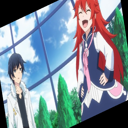

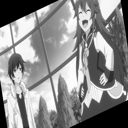

torch.Size([5, 3, 128, 128])


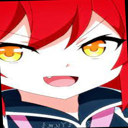

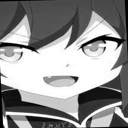

In [ ]:
to_pil = torchvision.transforms.ToPILImage()

for idx, image in enumerate(dataloader):
    res = to_pil(image["true_image"][0])
    bw = to_pil(image["gen_image"][0])
    print(image["true_image"].shape)
    display(res)
    display(bw)
    if idx == 2:
        break

In [ ]:
  class UNet(nn.Module):

    def unet_conv(self, ch_in, ch_out, is_leaky):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and ReLU/Leaky ReLU.
        """
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )

    def up(self, ch_in, ch_out):
        """
        Applies a 2D bilinear upsampling to the input image which scales
        the image 2x times, followed by a convolution with a 1x1 kernel.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, 1),
            nn.ReLU()
        )

    def __init__(self, is_leaky):
        """
        In the constructer, all the convolutional, upsampling and max pooling
        units are instantiated and assigned as member variables.
        """
        super(UNet, self).__init__()

        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        self.conv5 = self.unet_conv(512, 1024, is_leaky)

        # Pooling layer
        self.pool = nn.MaxPool2d(2)

        # First Upsampling layer
        self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)

        # First decoding layer
        self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)

        # Last layer
        self.conv10 = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        """
        An input tensor of a black and white image is accepted and
        passed through the U-Net model. A colored image in CieLAB color
        space is returned as the result.
        """
        # Encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))

        # Decoding path
        x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        x = self.conv7(torch.cat((x3, self.up2(x)), 1))
        x = self.conv8(torch.cat((x2, self.up3(x)), 1))
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)

        return x


class DNet(nn.Module):

    def unet_conv(self, ch_in, ch_out, generator_output=True):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and Leaky ReLU.
        """


        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ch_out, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2)
        )



    def __init__(self):
        super(DNet, self).__init__()
        """
        In the constructer, all the convolutional and max pooling units
        are instantiated and assigned as member variables.
        """
        # First layer
        self.conv1_x = self.unet_conv(3, 64)

        self.conv1_y = self.unet_conv(1, 64)

        # Second layer
        self.conv2 = self.unet_conv(64, 128)
        # Third layer
        self.conv3 = self.unet_conv(128, 256)
        # Fourth layer
        self.conv4 = self.unet_conv(256, 512)
        # Fifth layer
        self.conv5 = self.unet_conv(512, 1024)

        # Pooling layer
        self.pool = nn.MaxPool2d(2)

        # Last layer
        self.conv6 = nn.Linear(1024 * 128 * 2, 1)

    def forward(self, x_rgb, x_bw):
        """
        An input tensor of a colored image from either the generator or source
        is accepted and passed through the model. The probability of the image
        belonging to the source domain is returned as the result.
        """
        x1_rgb = self.conv1_x(x_rgb)
        x2_rgb = self.conv2(self.pool(x1_rgb))

        x1_bw = self.conv1_y(x_bw)
        x2_bw = self.conv2(self.pool(x1_bw))

        x2 = torch.cat((x2_rgb, x2_bw), 1)
        x4 = self.conv4(self.pool(x2))
        x5 = self.conv5(self.pool(x4))

        x6 = x5.view(batch_size, -1)
        m = nn.Sigmoid()
        x = m(self.conv6(x6))

        return x

In [ ]:
generator = 0
discriminator = 0
d_optimizer = 0
g_optimizer = 0
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [ ]:

##############################################################
# Initialise the generator and discriminator with the UNet and
# DNet architectures respectively.
generator = UNet(True)
discriminator = DNet()

##################################################################
# Utilize GPU for performing all the calculations performed in the
# forward and backward passes. Thus allocate all the generator and
# discriminator variables on the default GPU device.




generator.to(device)
discriminator.to(device)

###################################################################
# Create ADAM optimizer for the generator as well the discriminator.
# Create loss criterion for calculating the L1 and adversarial loss.
d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

d_criterion = nn.BCELoss()
g_criterion_1 = nn.BCELoss()
g_criterion_2 = nn.L1Loss()

In [ ]:
def train(PATH):
    g_lambda = 100
    smooth = 0.1
    for epoch in range(300):
        print("epoch_{}".format(epoch))
        # the generator and discriminator losses are averaged for the entire epoch.
        d_running_loss = 0.0
        g_running_loss = 0.0
        for i, data in enumerate(dataloader):
            images = data
            true_images = images["true_image"].to(device)
            bw_images = images["gen_image"].to(device)

            fake_images = generator(bw_images)

            d_optimizer.zero_grad()
            # Discriminator loss
            logits_real = discriminator(true_images, bw_images)
            logits_fake = discriminator(fake_images.detach(), bw_images)  # detach to avoid generator gradients
            d_real_loss = d_criterion(logits_real, torch.ones_like(logits_real) * (1 - smooth))
            d_fake_loss = d_criterion(logits_fake, torch.zeros_like(logits_fake))
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Generator loss
            g_optimizer.zero_grad()
            fake_logits = discriminator(fake_images, bw_images)
            g_fake_loss = g_criterion_1(fake_logits, torch.ones_like(fake_logits))
            g_image_distance_loss = g_lambda * g_criterion_2(fake_images, true_images)
            g_loss = g_fake_loss + g_image_distance_loss
            g_loss.backward()
            g_optimizer.step()

            d_running_loss += d_loss.item()
            g_running_loss += g_loss.item()

        # Print average losses for the epoch
        average_d_loss = d_running_loss / len(dataloader)
        average_g_loss = g_running_loss / len(dataloader)
        print('[%d] discriminator_loss: %.5f generator_loss: %.5f' % (epoch + 1, average_d_loss, average_g_loss))

        # Reset running losses
        d_running_loss = 0.0
        g_running_loss = 0.0

        # Save generator and discriminator
        torch.save(generator.state_dict(), os.path.join(PATH, "generator_epoch_{}.pth".format(epoch)))
        # torch.save(discriminator.state_dict(), os.path.join(PATH, "descriminator_epoch_{}.pth".format(epoch)))


In [ ]:
torch.save(generator.state_dict(), os.path.join("/content/drive/MyDrive/CISC 867 Project/models", "generator_epoch.pth"))

In [ ]:
train("/content/drive/MyDrive/CISC 867 Project/models")

epoch_0
[1] discriminator_loss: 8.37033 generator_loss: 48.98262
epoch_1
[2] discriminator_loss: 4.93729 generator_loss: 33.19180
epoch_2
[3] discriminator_loss: 5.08642 generator_loss: 24.94903
epoch_3
[4] discriminator_loss: 4.16088 generator_loss: 25.73608
epoch_4
[5] discriminator_loss: 6.10028 generator_loss: 23.48995
epoch_5
[6] discriminator_loss: 3.75138 generator_loss: 25.94212
epoch_6
[7] discriminator_loss: 4.59139 generator_loss: 21.32926
epoch_7
[8] discriminator_loss: 2.15805 generator_loss: 19.77941
epoch_8
[9] discriminator_loss: 2.74219 generator_loss: 19.81424
epoch_9
[10] discriminator_loss: 2.27016 generator_loss: 18.12790
epoch_10
[11] discriminator_loss: 2.53878 generator_loss: 20.99873
epoch_11
[12] discriminator_loss: 9.01954 generator_loss: 20.93290
epoch_12
[13] discriminator_loss: 4.83947 generator_loss: 17.81708
epoch_13
[14] discriminator_loss: 3.33277 generator_loss: 19.23833
epoch_14
[15] discriminator_loss: 2.21048 generator_loss: 18.76749
epoch_15
[16] 

KeyboardInterrupt: ignored

# Generate Colored Images



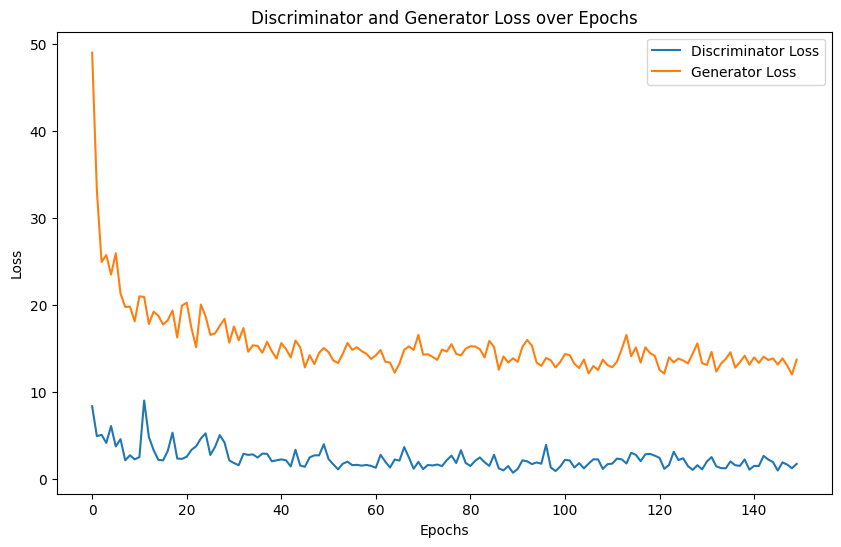

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your provided data
epochs = np.arange(0, 150)  # Adjusted the length of the epochs array
discriminator_loss = np.array([8.37033, 4.93729, 5.08642, 4.16088, 6.10028, 3.75138, 4.59139, 2.15805, 2.74219, 2.27016,
                               2.53878, 9.01954, 4.83947, 3.33277, 2.21048, 2.15310, 3.24813, 5.33166, 2.36562, 2.32573,
                               2.57151, 3.35908, 3.77525, 4.66869, 5.25887, 2.77273, 3.70520, 5.05324, 4.19756, 2.15066,
                               1.84324, 1.59647, 2.90779, 2.78023, 2.84034, 2.47273, 2.93104, 2.90753, 2.04855, 2.15843,
                               2.26648, 2.16007, 1.45560, 3.36816, 1.55805, 1.41922, 2.49515, 2.73030, 2.73269, 4.00209,
                               2.30199, 1.69879, 1.12322, 1.76395, 2.00902, 1.60695, 1.63676, 1.54735, 1.62888, 1.51583,
                               1.30252, 2.79492, 2.00263, 1.33051, 2.25154, 2.12424, 3.67530, 2.47279, 1.18920, 1.98449,
                               1.14768, 1.62291, 1.56757, 1.67072, 1.49615, 2.17310, 2.69862, 1.85093, 3.31913, 1.85301,
                               1.50721, 2.10118, 2.49011, 1.93698, 1.51283, 2.79953, 1.23361, 1.00315, 1.50038, 0.73371,
                               1.16111, 2.15712, 2.04582, 1.72149, 1.91307, 1.76839, 3.94739, 1.33124, 0.92696, 1.44369,
                               2.21507, 2.14609, 1.33146, 1.83670, 1.23530, 1.77476, 2.27543, 2.26256, 1.17030, 1.71487,
                               1.77960, 2.35938, 2.27045, 1.79466, 3.02917, 2.78820, 2.06179, 2.85476, 2.89804, 2.69056,
                               2.44176, 1.17702, 1.62220, 3.14545, 2.19061, 2.39348, 1.50160, 1.05942, 1.59778, 1.11579,
                               2.01408, 2.53294, 1.46833, 1.26353, 1.23663, 2.03155, 1.59432, 1.52076, 2.25540, 1.08541,
                               1.52299, 1.50506, 2.67160, 2.24729, 1.95297, 0.98261, 1.92426, 1.66766, 1.24871, 1.74942])

generator_loss = np.array([48.98262, 33.19180, 24.94903, 25.73608, 23.48995, 25.94212, 21.32926, 19.77941, 19.81424, 18.12790,
                           20.99873, 20.93290, 17.81708, 19.23833, 18.76749, 17.76079, 18.24897, 19.36588, 16.27272, 19.93658,
                           20.27256, 17.35701, 15.14209, 20.05492, 18.69920, 16.56944, 16.73527, 17.62128, 18.40317, 15.66486,
                           17.52889, 15.94418, 17.35299, 14.63354, 15.37578, 15.30224, 14.51387, 15.77810, 14.68907, 13.85125,
                           15.61973, 14.94644, 13.97640, 15.91727, 15.14566, 12.83301, 14.23957, 13.21149, 14.50970, 15.05693,
                           14.59110, 13.63257, 13.33814, 14.38708, 15.63871, 14.84899, 15.13624, 14.70723, 14.39658, 13.81323,
                           14.21345, 14.83262, 13.48535, 13.38557, 12.23021, 13.27904, 14.85189, 15.24765, 14.84406, 16.56930,
                           14.29673, 14.34180, 14.04197, 13.69995, 14.88590, 14.64855, 15.50249, 14.38852, 14.20962, 14.98334,
                           15.26867, 15.22840, 14.93209, 13.97381, 15.88397, 15.16518, 12.56805, 14.09304, 13.38912, 13.88046,
                           13.46853, 15.19615, 15.98340, 15.33477, 13.40252, 13.00712, 13.91632, 13.64962, 12.82277, 13.46415,
                           14.36384, 14.24700, 13.23317, 12.76230, 13.73802, 12.13861, 12.99897, 12.53027, 13.72417, 13.09274,
                           12.85219, 13.50000, 14.92457, 16.55787, 14.11423, 15.13099, 13.38216, 15.14259, 14.47461, 14.14645,
                           12.53825, 12.13059, 13.98970, 13.41217, 13.84917, 13.62379, 13.28761, 14.41245, 15.58507, 13.31540,
                           13.11172, 14.61488, 12.35371, 13.26982, 13.81107, 14.57252, 12.80836, 13.43122, 14.17820, 13.14355,
                           13.98974, 13.35079, 14.06501, 13.67932, 13.87190, 13.16003, 13.86221, 13.03419, 12.02058, 13.72407])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, discriminator_loss, label='Discriminator Loss')
plt.plot(epochs, generator_loss, label='Generator Loss')
plt.title('Discriminator and Generator Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from prettytable import PrettyTable

# Replace the placeholder values with your actual data
epochs = list(range(151))
discriminator_loss = [8.37033, 4.93729, 5.08642, 4.16088, 6.10028, 3.75138, 4.59139, 2.15805, 2.74219, 2.27016,
                      2.53878, 9.01954, 4.83947, 3.33277, 2.21048, 2.15310, 3.24813, 5.33166, 2.36562, 2.32573,
                      2.57151, 3.35908, 3.77525, 4.66869, 5.25887, 2.77273, 3.70520, 5.05324, 4.19756, 2.15066,
                      1.84324, 1.59647, 2.90779, 2.78023, 2.84034, 2.47273, 2.93104, 2.90753, 2.04855, 2.15843,
                      2.26648, 2.16007, 1.45560, 3.36816, 1.55805, 1.41922, 2.49515, 2.73030, 2.73269, 4.00209,
                      2.30199, 1.69879, 1.12322, 1.76395, 2.00902, 1.60695, 1.63676, 1.54735, 1.62888, 1.51583,
                      1.30252, 2.79492, 2.00263, 1.33051, 2.25154, 2.12424, 3.67530, 2.47279, 1.18920, 1.98449,
                      1.14768, 1.62291, 1.56757, 1.67072, 1.49615, 2.17310, 2.69862, 1.85093, 3.31913, 1.85301,
                      1.50721, 2.10118, 2.49011, 1.93698, 1.51283, 2.79953, 1.23361, 1.00315, 1.50038, 0.73371,
                      1.16111, 2.15712, 2.04582, 1.72149, 1.91307, 1.76839, 3.94739, 1.33124, 0.92696, 1.44369,
                      2.21507, 2.14609, 1.33146, 1.83670, 1.23530, 1.77476, 2.27543, 2.26256, 1.17030, 1.71487,
                      1.77960, 2.35938, 2.27045, 1.79466, 3.02917, 2.78820, 2.06179, 2.85476, 2.89804, 2.69056,
                      2.44176, 1.17702, 1.62220, 3.14545, 2.19061, 2.39348, 1.50160, 1.05942, 1.59778, 1.11579,
                      2.01408, 2.53294, 1.46833, 1.26353, 1.23663, 2.03155, 1.59432, 1.52076, 2.25540, 1.08541,
                      1.52299, 1.50506, 2.67160, 2.24729, 1.95297, 0.98261, 1.92426, 1.66766, 1.24871, 1.74942]

generator_loss = [48.98262, 33.19180, 24.94903, 25.73608, 23.48995, 25.94212, 21.32926, 19.77941, 19.81424, 18.12790,
                  20.99873, 20.93290, 17.81708, 19.23833, 18.76749, 17.76079, 18.24897, 19.36588, 16.27272, 19.93658,
                  20.27256, 17.35701, 15.14209, 20.05492, 18.69920, 16.56944, 16.73527, 17.62128, 18.40317, 15.66486,
                  17.52889, 15.94418, 17.35299, 14.63354, 15.37578, 15.30224, 14.51387, 15.77810, 14.68907, 13.85125,
                  15.61973, 14.94644, 13.97640, 15.91727, 15.14566, 12.83301, 14.23957, 13.21149, 14.50970, 15.05693,
                  14.59110, 13.63257, 13.33814, 14.38708, 15.63871, 14.84899, 15.13624, 14.70723, 14.39658, 13.81323,
                  14.21345, 14.83262, 13.48535, 13.38557, 12.23021, 13.27904, 14.85189, 15.24765, 14.84406, 16.56930,
                  14.29673, 14.34180, 14.04197, 13.69995, 14.88590, 14.64855, 15.50249, 14.38852, 14.20962, 14.98334,
                  15.26867, 15.22840, 14.93209, 13.97381, 15.88397, 15.16518, 12.56805, 14.09304, 13.38912, 13.88046,
                  13.46853, 15.19615, 15.98340, 15.33477, 13.40252, 13.00712, 13.91632, 13.64962, 12.82277, 13.46415,
                  14.36384, 14.24700, 13.23317, 12.76230, 13.73802, 12.13861, 12.99897, 12.53027, 13.72417, 13.09274,
                  12.85219, 13.50000, 14.92457, 16.55787, 14.11423, 15.13099, 13.38216, 15.14259, 14.47461, 14.14645,
                  12.53825, 12.13059, 13.98970, 13.41217, 13.84917, 13.62379, 13.28761, 14.41245, 15.58507, 13.31540,
                  13.11172, 14.61488, 12.35371, 13.26982, 13.81107, 14.57252, 12.80836, 13.43122, 14.17820, 13.14355,
                  13.98974, 13.35079, 14.06501, 13.67932, 13.87190, 13.16003, 13.86221, 13.03419, 12.02058, 13.72407]

# Creating the PrettyTable object
table = PrettyTable()

# Defining the column names and adding data
table.field_names = ["Epoch", "Discriminator Loss", "Generator Loss"]
for epoch, disc_loss, gen_loss in zip(epochs, discriminator_loss, generator_loss):
    table.add_row([epoch, disc_loss, gen_loss])

# Printing the table
print(table)


+-------+--------------------+----------------+
| Epoch | Discriminator Loss | Generator Loss |
+-------+--------------------+----------------+
|   0   |      8.37033       |    48.98262    |
|   1   |      4.93729       |    33.1918     |
|   2   |      5.08642       |    24.94903    |
|   3   |      4.16088       |    25.73608    |
|   4   |      6.10028       |    23.48995    |
|   5   |      3.75138       |    25.94212    |
|   6   |      4.59139       |    21.32926    |
|   7   |      2.15805       |    19.77941    |
|   8   |      2.74219       |    19.81424    |
|   9   |      2.27016       |    18.1279     |
|   10  |      2.53878       |    20.99873    |
|   11  |      9.01954       |    20.9329     |
|   12  |      4.83947       |    17.81708    |
|   13  |      3.33277       |    19.23833    |
|   14  |      2.21048       |    18.76749    |
|   15  |       2.1531       |    17.76079    |
|   16  |      3.24813       |    18.24897    |
|   17  |      5.33166       |    19.365

In [ ]:
test_images_path = "/content/drive/MyDrive/CISC 867 Project/test_images"
generated_images_path = "/content/drive/MyDrive/CISC 867 Project/generated_image"
images_path = [file for file in os.listdir(test_images_path) if file.endswith(".jpg")]

# inference 50 epoch

In [ ]:
# load generator weights and parameters
generator_test = UNet(True)
generator_test.to(device)
generator_test.load_state_dict(torch.load("/content/drive/MyDrive/CISC 867 Project/models/generator_epoch_49.pth", map_location=torch.device('cpu')))
generator_test.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

1.jpg


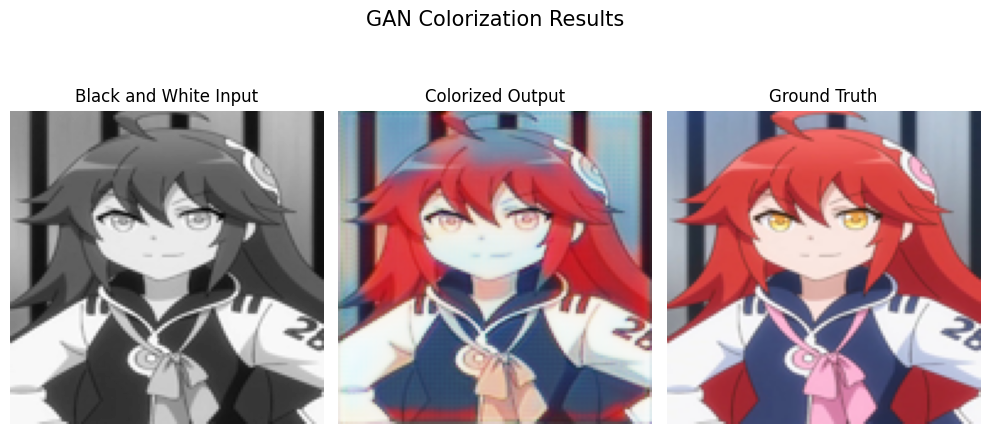

7.jpg


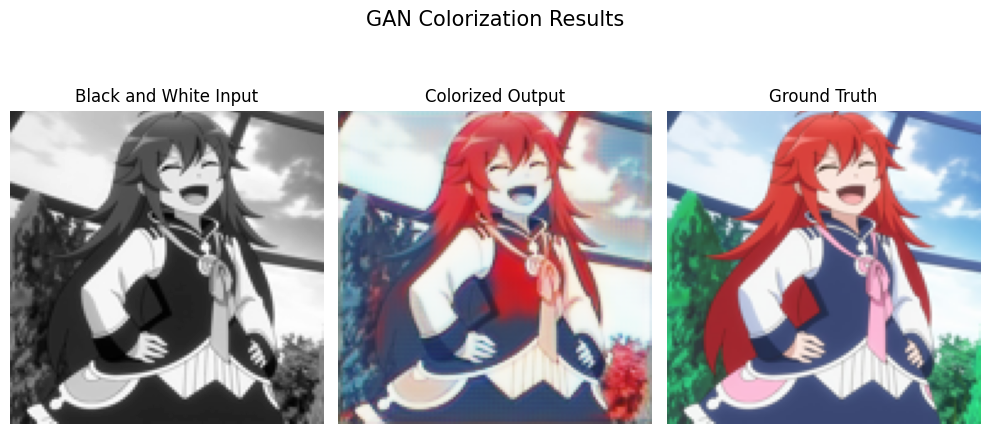

4.jpg


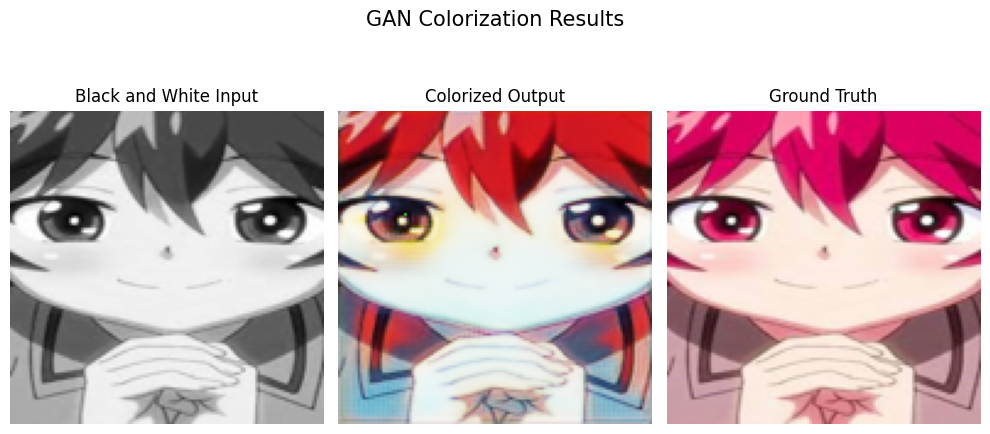

In [ ]:
from PIL import Image
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Assuming you have the necessary functions and variables defined
# device, images_path, test_images_path, to_pil, generator_test

# Set the desired size for all images
output_size = (128, 128)

# Create a transform to convert PIL Image to PyTorch tensor
to_tensor = transforms.ToTensor()

for idx, img_path in enumerate(images_path):
    img = Image.open(os.path.join(test_images_path, img_path))
    print(img_path)

    img = img.resize(output_size)  # Resize all images to the desired size
    img_gray = img.convert("L")  # Convert to grayscale

    # Convert grayscale image to PyTorch tensor
    img_tensor = to_tensor(img_gray)

    c, h, w = img_tensor.size()
    gen_input = img_tensor.view(1, c, h, w)  # Adding 1 more dimension
    gen_gpu = gen_input.to(device)
    gen_output = generator_test(gen_gpu)

    # Resize the colorized image to match the input size
    output_image = to_pil(gen_output.view(3, h, w).cpu())
    output_image = output_image.resize(output_size)

    # Save the resized colorized image
    output_image.save("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))

    # Resize the black and white input
    img_gray_resized = img_gray.resize(output_size)

    # Resize the ground truth image
    img_ground_truth = Image.open(os.path.join("/content/drive/MyDrive/CISC 867 Project/test_images", img_path))
    img_ground_truth_resized = img_ground_truth.resize(output_size)

    # Read images from disk
    image1 = Image.fromarray(np.array(img_gray_resized))  # Black and white input
    image2 = Image.fromarray(np.array(img_ground_truth_resized))  # Ground truth
    image3 = mpimg.imread("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))  # Colorized output

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns

    # Plot the first image
    axes[0].imshow(image1, cmap="gray")
    axes[0].set_title('Black and White Input')

    # Plot the second image
    axes[2].imshow(image2, cmap="cool")
    axes[2].set_title('Ground Truth')

    # Plot the third image
    axes[1].imshow(image3, cmap="cool")
    axes[1].set_title('Colorized Output')

    # Hide axis ticks and labels for a cleaner display
    for ax in axes:
        ax.axis('off')

    fig.suptitle('GAN Colorization Results', fontsize=15)
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# inference 100 epoch

In [ ]:
# load generator weights and parameters
generator_test = UNet(True)
generator_test.to(device)
generator_test.load_state_dict(torch.load("/content/drive/MyDrive/CISC 867 Project/models/generator_epoch_99.pth", map_location=torch.device('cpu')))
generator_test.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

1.jpg


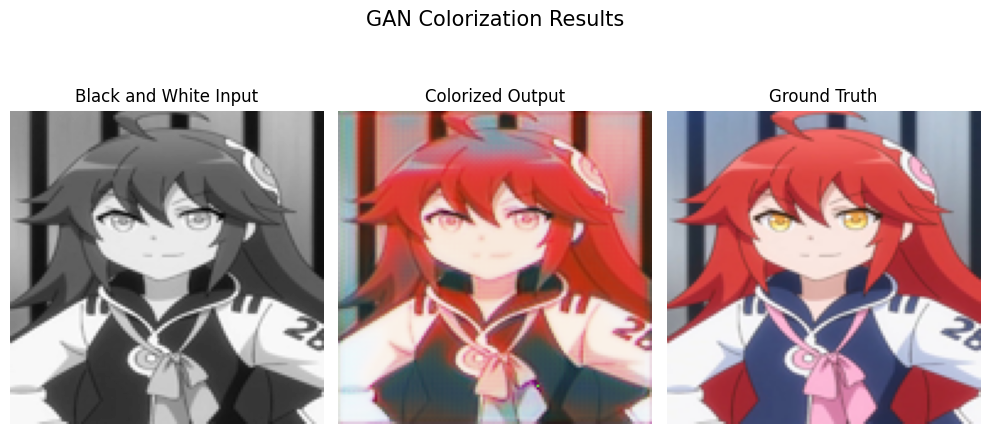

7.jpg


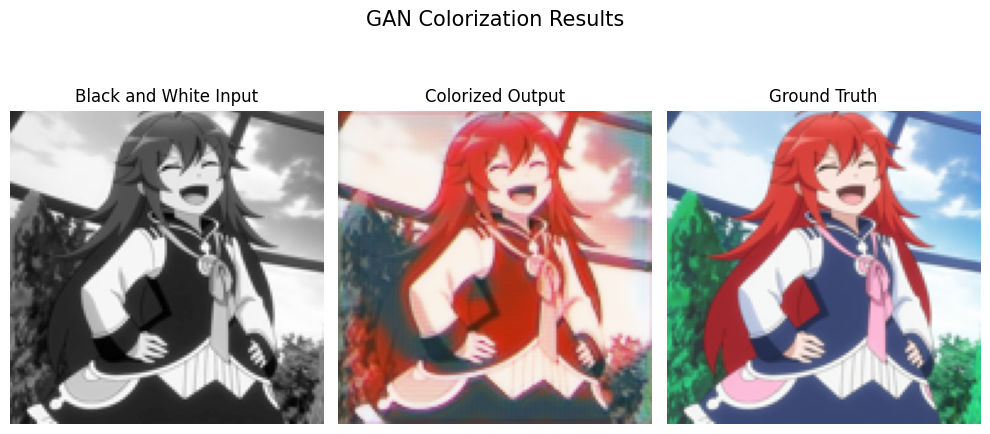

4.jpg


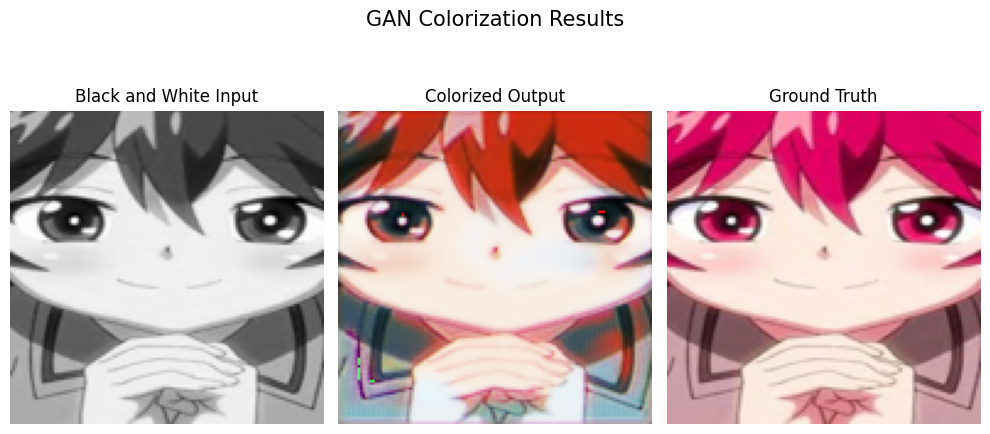

In [ ]:
from PIL import Image
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Assuming you have the necessary functions and variables defined
# device, images_path, test_images_path, to_pil, generator_test

# Set the desired size for all images
output_size = (128, 128)

# Create a transform to convert PIL Image to PyTorch tensor
to_tensor = transforms.ToTensor()

for idx, img_path in enumerate(images_path):
    img = Image.open(os.path.join(test_images_path, img_path))
    print(img_path)

    img = img.resize(output_size)  # Resize all images to the desired size
    img_gray = img.convert("L")  # Convert to grayscale

    # Convert grayscale image to PyTorch tensor
    img_tensor = to_tensor(img_gray)

    c, h, w = img_tensor.size()
    gen_input = img_tensor.view(1, c, h, w)  # Adding 1 more dimension
    gen_gpu = gen_input.to(device)
    gen_output = generator_test(gen_gpu)

    # Resize the colorized image to match the input size
    output_image = to_pil(gen_output.view(3, h, w).cpu())
    output_image = output_image.resize(output_size)

    # Save the resized colorized image
    output_image.save("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))

    # Resize the black and white input
    img_gray_resized = img_gray.resize(output_size)

    # Resize the ground truth image
    img_ground_truth = Image.open(os.path.join("/content/drive/MyDrive/CISC 867 Project/test_images", img_path))
    img_ground_truth_resized = img_ground_truth.resize(output_size)

    # Read images from disk
    image1 = Image.fromarray(np.array(img_gray_resized))  # Black and white input
    image2 = Image.fromarray(np.array(img_ground_truth_resized))  # Ground truth
    image3 = mpimg.imread("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))  # Colorized output

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns

    # Plot the first image
    axes[0].imshow(image1, cmap="gray")
    axes[0].set_title('Black and White Input')

    # Plot the second image
    axes[2].imshow(image2, cmap="cool")
    axes[2].set_title('Ground Truth')

    # Plot the third image
    axes[1].imshow(image3, cmap="cool")
    axes[1].set_title('Colorized Output')

    # Hide axis ticks and labels for a cleaner display
    for ax in axes:
        ax.axis('off')

    fig.suptitle('GAN Colorization Results', fontsize=15)
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# inference 150 epoch

In [ ]:
# load generator weights and parameters
generator_test = UNet(True)
generator_test.to(device)
generator_test.load_state_dict(torch.load("/content/drive/MyDrive/CISC 867 Project/models/generator_epoch_149.pth", map_location=torch.device('cpu')))
generator_test.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256

1.jpg


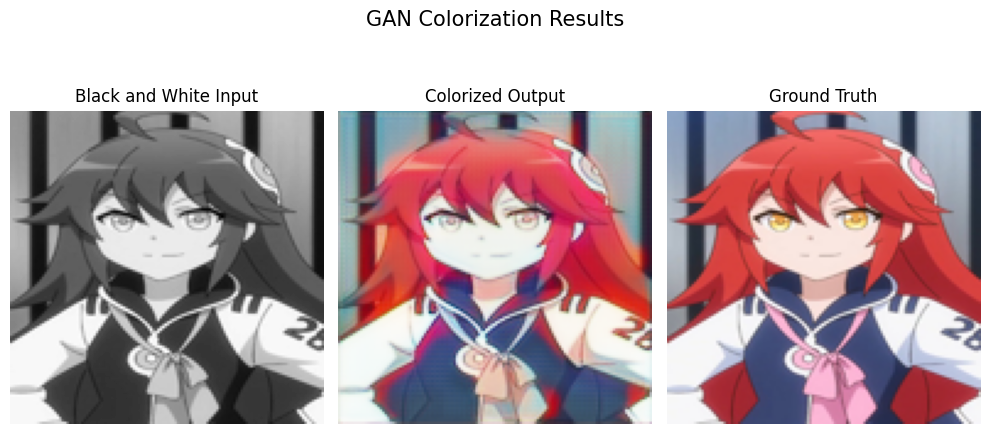

7.jpg


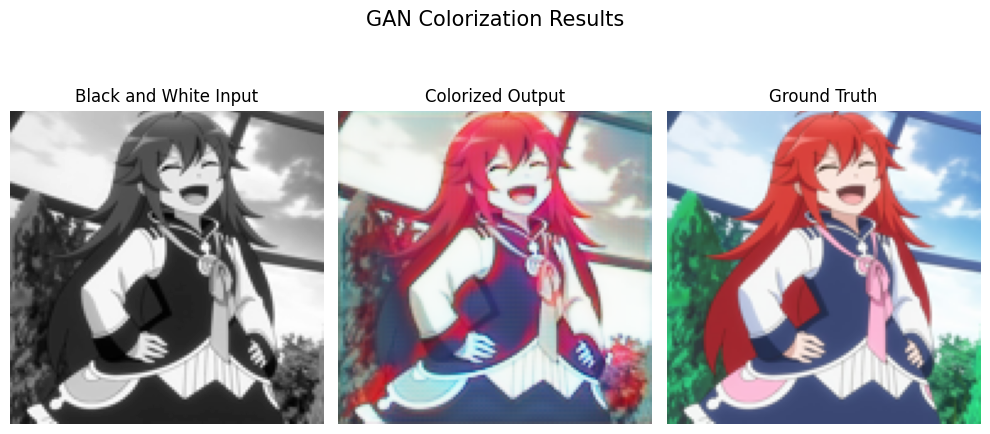

4.jpg


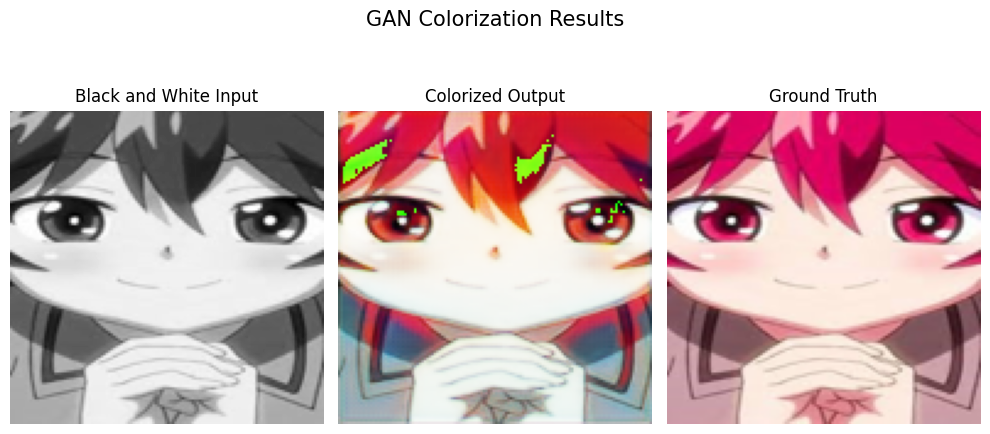

In [ ]:
from PIL import Image
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Assuming you have the necessary functions and variables defined
# device, images_path, test_images_path, to_pil, generator_test

# Set the desired size for all images
output_size = (128, 128)

# Create a transform to convert PIL Image to PyTorch tensor
to_tensor = transforms.ToTensor()

for idx, img_path in enumerate(images_path):
    img = Image.open(os.path.join(test_images_path, img_path))
    print(img_path)

    img = img.resize(output_size)  # Resize all images to the desired size
    img_gray = img.convert("L")  # Convert to grayscale

    # Convert grayscale image to PyTorch tensor
    img_tensor = to_tensor(img_gray)

    c, h, w = img_tensor.size()
    gen_input = img_tensor.view(1, c, h, w)  # Adding 1 more dimension
    gen_gpu = gen_input.to(device)
    gen_output = generator_test(gen_gpu)

    # Resize the colorized image to match the input size
    output_image = to_pil(gen_output.view(3, h, w).cpu())
    output_image = output_image.resize(output_size)

    # Save the resized colorized image
    output_image.save("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))

    # Resize the black and white input
    img_gray_resized = img_gray.resize(output_size)

    # Resize the ground truth image
    img_ground_truth = Image.open(os.path.join("/content/drive/MyDrive/CISC 867 Project/test_images", img_path))
    img_ground_truth_resized = img_ground_truth.resize(output_size)

    # Read images from disk
    image1 = Image.fromarray(np.array(img_gray_resized))  # Black and white input
    image2 = Image.fromarray(np.array(img_ground_truth_resized))  # Ground truth
    image3 = mpimg.imread("/content/drive/MyDrive/CISC 867 Project/generated_image/gen_image_{}.png".format(idx + 1))  # Colorized output

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns

    # Plot the first image
    axes[0].imshow(image1, cmap="gray")
    axes[0].set_title('Black and White Input')

    # Plot the second image
    axes[2].imshow(image2, cmap="cool")
    axes[2].set_title('Ground Truth')

    # Plot the third image
    axes[1].imshow(image3, cmap="cool")
    axes[1].set_title('Colorized Output')

    # Hide axis ticks and labels for a cleaner display
    for ax in axes:
        ax.axis('off')

    fig.suptitle('GAN Colorization Results', fontsize=15)
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
